In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from GLM_regression import *
plt.rcParams.update({'font.size': 12,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'legend.frameon':    False,})

### 1. Choose which dataset to use

 All datasets must be in the "datasets" folder.

In [2]:
filename = "SSTindivsomata_GLM"
# filename = "NDNFindivsomata_GLM"
# filename = "EC_GLM"

filepath = os.path.join("datasets", filename+".mat")
reorganized_data, variable_list = preprocess_data(filepath)
GLM_params = fit_GLM(reorganized_data, quintile=None, regression='ridge')

### 2. (Optional) Filter the data

Skip this cell if you want to include all neurons in the analysis.

For example, you can keep only the cells with GLM prediction R<sup>2</sup> > 0.8, or the top 20% of cells based on Velocity weights.

In [3]:
reorganized_data, GLM_params= filter_neurons_by_metric(reorganized_data, GLM_params, variable_list, 
                                                       metric = 'R2',        # Options: 'R2', 'trial correlations', 'Licks', 'Reward_loc', 'Velocity', '#1', '#2', etc.
                                                       threshold = 0.8, 
                                                       scale_type = 'value', # Options: 'value', 'percentile', 'std'
                                                       keep = 'top'          # Options: 'top', 'bottom'
                                                       )

### 3. Visualize the data

The animal and cell numbers are based on your original dataset, so e.g. 'cell_1' does not exist because it has been removed from the data.

(Any cell with all zeros or all NaNs is automatically removed.)

pearson R2 across all trials: 0.3767958110875293
pearson R2 (average prediction vs average activity): 0.9854873346065469


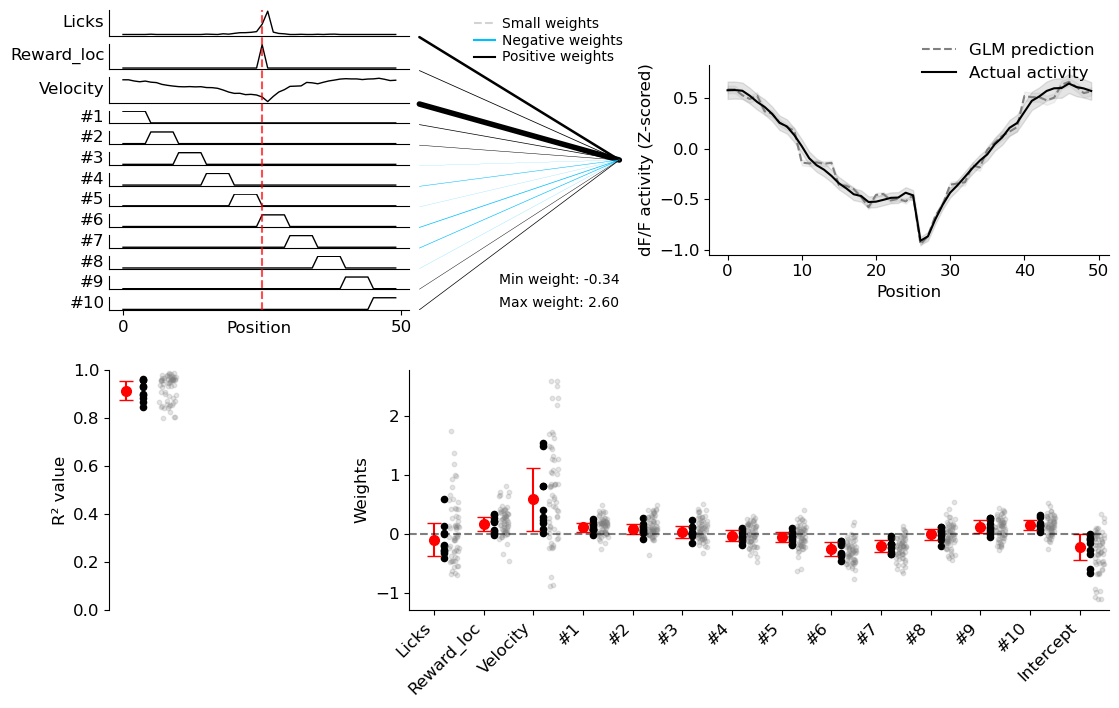

In [4]:
plot_combined_figure(reorganized_data, GLM_params, variable_list, model_name=filename, sort_by='R2', save=False)
# plot_combined_figure(reorganized_data, GLM_params, variable_list, model_name=filename, animal='animal_2', cell='cell_3', save=False)

Top neuron for Reward_loc, with weight: 0.8113415344734144
Best neuron: cell_2, animal_7
pearson R2 across all trials: 0.16725266369126623
pearson R2 (average prediction vs average activity): 0.9007167866131969
pearson R2 across all trials: 0.2526921103181154
pearson R2 (average prediction vs average activity): 0.9749702603484584


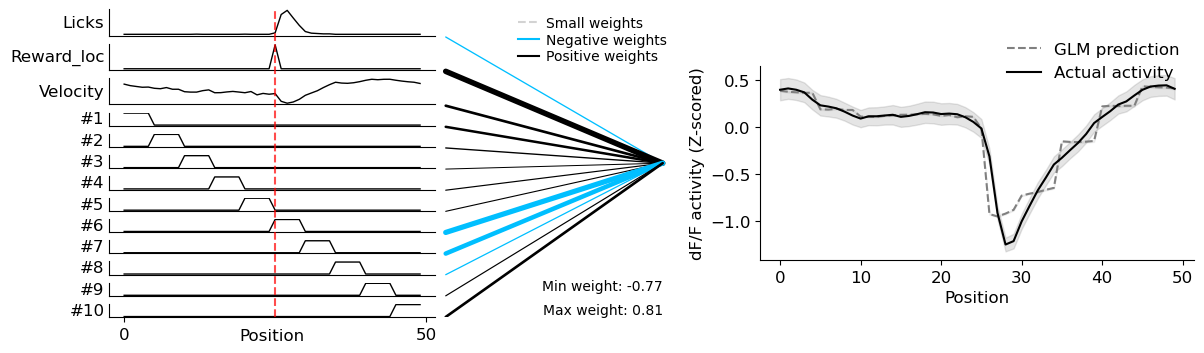

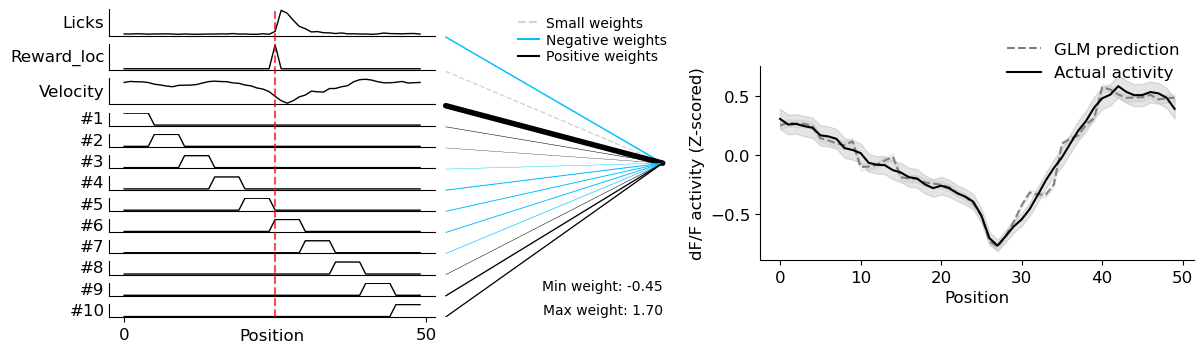

In [5]:
'''
If you want to visualize the GLM results for a specific example neuron, you can either specify the animal and cell number, 
or pick the top neuron based on a specific metric (such as weight for Reward_loc)
'''

plot_example_neuron(reorganized_data, GLM_params, variable_list, sort_by="Reward_loc")
plot_example_neuron(reorganized_data, GLM_params, variable_list, animal='animal_4', cell='cell_3')

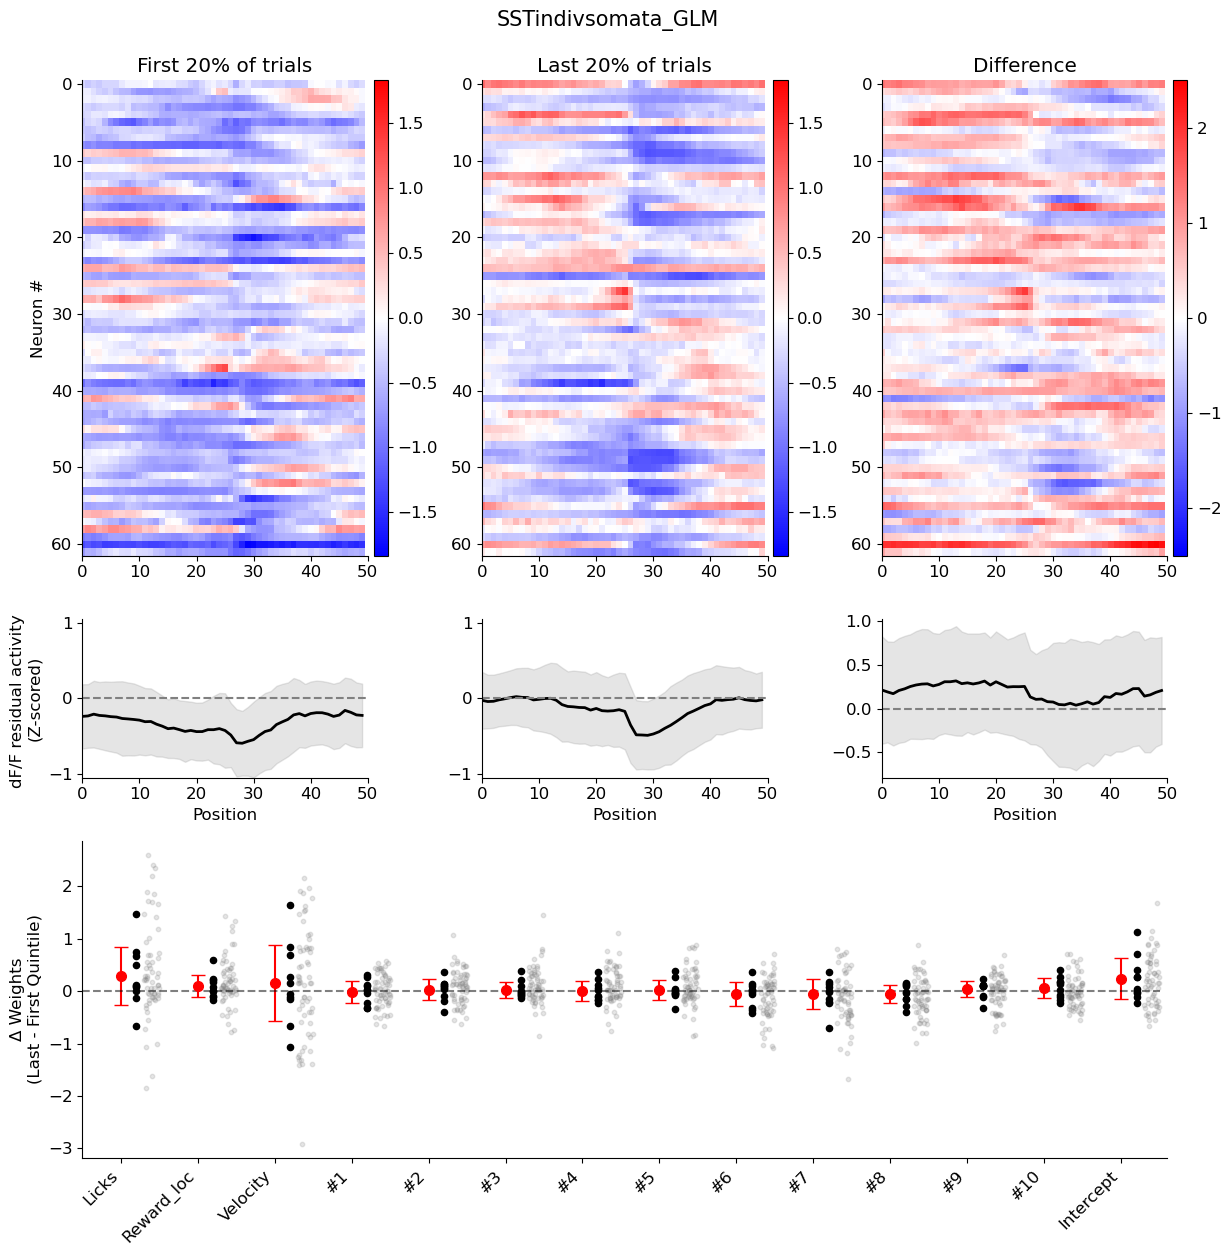

In [50]:
'''
Visualize the dF/F traces after subtracting the GLM prediction based on only Velocity (all other weights+intercept set to 0).
The dF/F data is Z-scored across all trials, and the 2 GLMs are trained on different subsets of this data.
You can compare any 2 quintiles of the data.
'''

plot_quintile_comparison(reorganized_data, variable_list, filename, quintiles=(1,5), save=False)

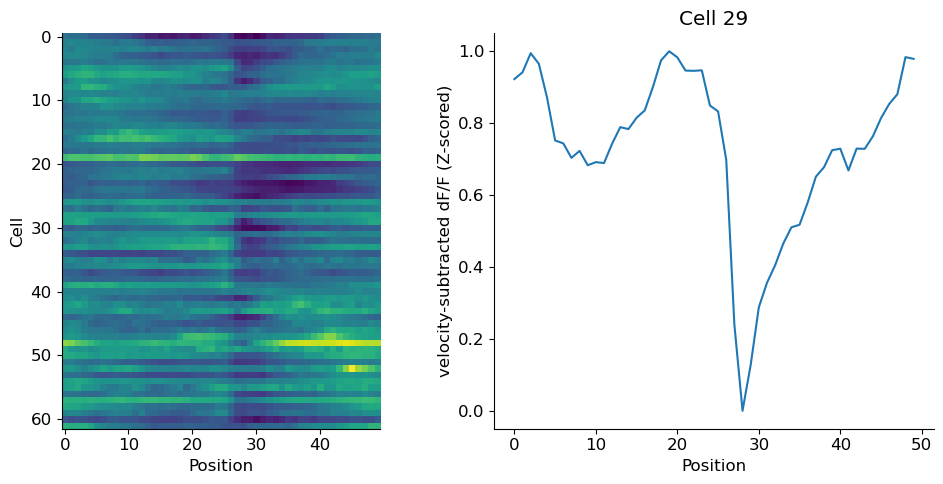

In [52]:
cell = 29

avg_residuals, GLM_params = compute_velocity_subtracted_residuals(reorganized_data, variable_list, quintile=3)
sort_idx = np.argsort(np.argmax(avg_residuals, axis=1))
sorted_avg_residuals = avg_residuals[sort_idx]

# Renormalize between 0 and 1
cell_residual = sorted_avg_residuals[cell]
cell_residual = (cell_residual - np.min(cell_residual)) / (np.max(cell_residual) - np.min(cell_residual))

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(sorted_avg_residuals, aspect='equal', cmap='viridis', interpolation='none')
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Cell')

ax[1].plot(cell_residual)
ax[1].set_xlabel('Position')
ax[1].set_ylabel('velocity-subtracted dF/F (Z-scored)')
ax[1].set_title('Cell %d' % cell)

plt.tight_layout()
plt.show()